1. Retrain the networks with seed 42 and deterministic
2. Save them via pickle
3. When loading the model, make sure to 
import pickle
from experiments.hmm.classifier import StateClassifier, StateClassifierNet

TODO:
- (DONE) Align batches to visualize correct data
- (DONE) Did the author mix up features and times? Does he visualize them ever?. NOPE! https://github.com/JonathanCrabbe/Dynamask/blob/637d84568a3a3af56fbfd343bd9ecd474fe6f633/attribution/mask.py#L238C45-L238C62
- instead of mask saliency, visualize proposed metric for importance: (1-m)*|NN(x) - x| for a single sample. The higher this value, the more perturbed the data is.
- visualize: original, background, mask, perturbed = m * x + (1 - m) * background

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch as th
from pytorch_lightning import seed_everything

from tint.datasets import Arma

SEED = 42
seed_everything(seed=SEED, workers=True)
# plt.style.use("ggplot")

Seed set to 42


42

In [110]:

arma = Arma()
arma.download()  # This method generates the dataset
inputs = arma.preprocess()["x"]
true_saliency = arma.true_saliency(dim=1)

In [113]:
res_arma = arma.get_white_box(inputs, true_saliency)

In [114]:
res_arma.size()

torch.Size([1000, 50])

In [ ]:
# OUTPUT SIZE DEPENDS ON THE CLASSIFIER!!!!

In [2]:
from tint.datasets import HMM

hmm = HMM(n_folds=5, fold=0, seed=SEED)
hmm.download(split="train")
hmm.download(split="test")
x_train = hmm.preprocess(split="train")["x"]
x_test = hmm.preprocess(split="test")["x"]
y_test = hmm.preprocess(split="test")["y"]
true_saliency = hmm.true_saliency(split="test")
print("batch size, time series length, no. features", x_test.size())

batch size, time series length, no. features torch.Size([200, 200, 3])


In [3]:
SAL_ID = 0
saliencies = {
    "true": true_saliency[SAL_ID].T,
    "balh": true_saliency[SAL_ID].T,
}
plot_saliency2(saliencies)

NameError: name 'plot_saliency2' is not defined

In [6]:
import pickle
from classifier import StateClassifier, StateClassifierNet


def get_classifier(experiment):
    if experiment == "hmm":
        # From HMM experiments
        classifier = StateClassifierNet(
            feature_size=3,
            n_state=2,
            hidden_size=200,
            regres=True,
            loss="cross_entropy",
            lr=0.0001,
            l2=1e-3,
        )
        checkpoint = "../../models/hmm_42_classifier.ckpt"

        classifier.load_state_dict(th.load(checkpoint))

    return classifier


def save_explainer(explainer, mlp=None, explainer_name="explainer"):
    if mlp is not None:
        with open(f"mlp_{explainer_name}.pkl", "wb") as f:
            pickle.dump(mlp, f)

    with open(f"{explainer_name}.pkl", "wb") as f:
        pickle.dump(explainer, f)


def load_explainer(explainer_name="explainer"):
    with open(f"{explainer_name}_attr.pkl", "rb") as f:
        attr = pickle.load(f)

    classifier = get_classifier("hmm")

    with open(f"{explainer_name}_explainer.pkl", "rb") as f:
        ecl_inputsplainer = pickle.load(f)

    with open(f"{explainer_name}_mask_net.pkl", "rb") as f:
        mask_net = pickle.load(f)

    with open(f"{explainer_name}_perturbation_net.pkl", "rb") as f:
        perturbation_net = pickle.load(f)

    return attr, mask_net, ecl_inputsplainer, perturbation_net, classifier

In [7]:
(
    extremal_attr,
    extremal_mask_net,
    extremal_explainer,
    perturbation_net,
    classifier,
) = load_explainer("../../42_hmm_extremal")

In [22]:
# Switch to eval
classifier.eval()

StateClassifierNet(
  (net): StateClassifier(
    (rnn): GRU(3, 200, batch_first=True)
    (regressor): Sequential(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=200, out_features=2, bias=True)
    )
  )
  (_loss): CrossEntropyLoss()
  (train_acc): BinaryAccuracy()
  (train_pre): BinaryPrecision()
  (train_rec): BinaryRecall()
  (train_auroc): BinaryAUROC()
  (val_acc): BinaryAccuracy()
  (val_pre): BinaryPrecision()
  (val_rec): BinaryRecall()
  (val_auroc): BinaryAUROC()
  (test_acc): BinaryAccuracy()
  (test_pre): BinaryPrecision()
  (test_rec): BinaryRecall()
  (test_auroc): BinaryAUROC()
)

In [8]:
# Taken from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency(ts_data, perturbed, saliency_list, figsize=None):
    if figsize is None:
        figsize = (10, len(ts_data) * 1.2)
    ax011 = []
    i = 0

    fig, axn = plt.subplots(len(ts_data), 1, sharex=True, sharey=True, figsize=figsize)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    for channel in ts_data:
        # print(ts_data.shape)
        # ax011.append(plt.subplot(len(ts_data[0]),1,i+1))
        # ax012.append(ax011[i].twinx())
        # ax011[i].set_facecolor("#440154FF")
        axn012 = axn[i].twinx()

        # Plot saliency
        sns.heatmap(
            saliency_list[i].reshape(1, -1),
            fmt="g",
            cmap="viridis",
            cbar=i == 0,
            cbar_ax=None if i else cbar_ax,
            ax=axn[i],
            yticklabels=False,
            vmin=0,
            vmax=1,
        )
        # Plot original data
        sns.lineplot(
            x=range(0, len(channel.reshape(-1))),
            y=channel.flatten(),
            ax=axn012,
            color="white",
        )
        # Plot learned perturbations
        sns.lineplot(
            x=range(0, len(channel.reshape(-1))),
            # The perturbation comes from an NN, need to detach it
            y=perturbed[i].detach().numpy(),
            ax=axn012,
            color="red",
        )
        plt.xlabel("Time", fontweight="bold", fontsize="large")
        plt.ylabel(f"Feature {i}", fontweight="bold", fontsize="large")
        i = i + 1
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

In [9]:
# Taken from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency2(saliencies, figsize=None):
    N = len(saliencies)
    if figsize is None:
        figsize = (10, N * 2)

    fig, axn = plt.subplots(
        int(np.ceil(N / 2)), 2, sharex=True, sharey=True, figsize=figsize
    )
    axn = axn.flatten()
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    color_map = sns.diverging_palette(10, 133, as_cmap=True)

    for idx, (method, saliency) in enumerate(saliencies.items()):
        sns.heatmap(
            saliency,
            cmap=color_map,
            cbar=idx == 0,
            cbar_ax=None if idx else cbar_ax,
            cbar_kws={"label": "Mask"},
            ax=axn[idx],
            yticklabels=False,
            linecolor="#d8cbd5",
            linewidths=0.4,
            vmin=0,
            vmax=1,
        )
        axn[idx].set_title(f"Method: {method}")
        axn[idx].set_xlabel("Time")
        axn[idx].set_ylabel("Feature number")

    fig.suptitle("Mask coefficients over time")
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

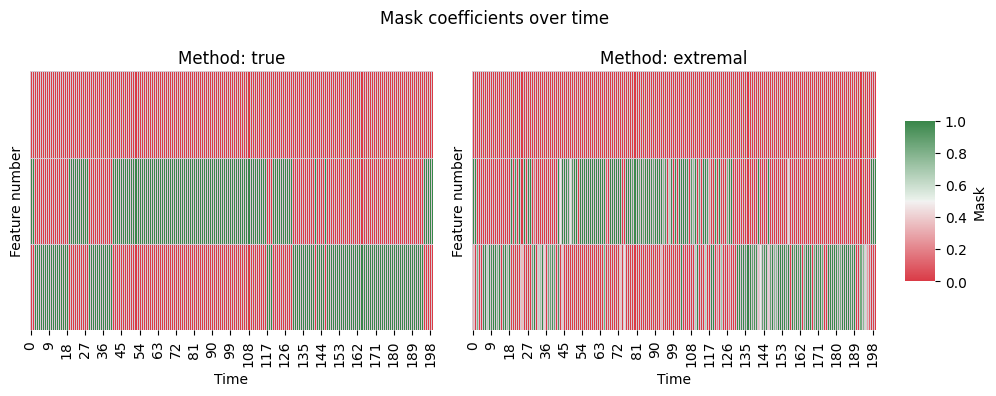

In [11]:
SAL_ID = 100
saliencies = {
    "true": true_saliency[SAL_ID].T,
    "extremal": extremal_attr[SAL_ID].T,
}
plot_saliency2(saliencies)

In [13]:
from tint.metrics.white_box import aup, aur, rmse

print(f"AUP: {aup(extremal_attr, true_saliency):.4}")
print(f"AUR: {aur(extremal_attr, true_saliency):.4}")
print(f"RMSE: {rmse(extremal_attr, true_saliency):.4}")

AUP: 0.9149
AUR: 0.7566
RMSE: 0.2915


## Visualize learned perturbations

In [15]:
x_test[:100].size()

torch.Size([100, 200, 3])

In [98]:
# extremal_attr,
# extremal_mask_net,
# extremal_explainer,
# perturbation_net,
# classifier

# perturbations = extremal_mask_net.net.model(x_test[:100])
# perturbations.size()

perturbations = perturbation_net(x_test[:100])
perturbations.size()

torch.Size([100, 200, 3])

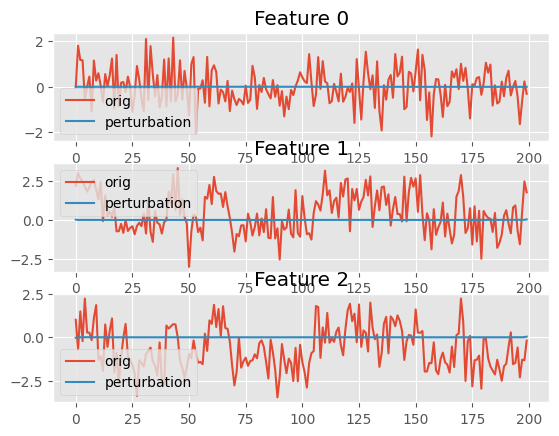

In [99]:
sid = 20
input_sample = x_test[:100][sid].T 
pert_sample = perturbations[sid].T
tot_feat, ts_length = pert_sample.size()
xs = np.arange(ts_length)
fig, axs = plt.subplots(tot_feat, 1)
for i in range(tot_feat):
    axs[i].plot(xs, input_sample[i], label="orig")
    axs[i].plot(xs, pert_sample[i].detach(), label="perturbation")
    axs[i].set_title(f"Feature {i}")
    axs[i].legend()
plt.show()

In [32]:
inputs = x_test.clone()

In [41]:
batch_size = 100  # Network was trained with this
sample_id = 0  # Take the first data sample
batch_idx = sample_id // batch_size
sample_id = sample_id % batch_size  # recalculate sample id w.r.t the batch
FROM_B = batch_idx * batch_size
TO_B = batch_idx * batch_size + batch_size
x = inputs[FROM_B:TO_B]
extremal_attr_batch = extremal_attr[FROM_B:TO_B]
print(x.size())
print(extremal_attr_batch.size())
# Create a baseline for each time series in a sample
# The baseline is a mean, computed for each time series
# baseline = th.ones_like(x) * th.mean(x, axis=1).reshape(-1, 1)
baseline = th.zeros_like(x)
target = None
# ARMA
# additional_forward_args = (true_saliency[FROM_B:TO_B],)
# HMM
additional_forward_args = (True,)

torch.Size([100, 200, 3])
torch.Size([100, 200, 3])


In [40]:
target

In [36]:
# Get perturbed output
# y_hat1 is computed by masking important features
# y_hat2 is computed by masking unimportant features
yhat1, yhat2 = extremal_mask_net(
    x.clone().float(), batch_idx, baseline, target, *additional_forward_args
)
yhat1.size()

torch.Size([100, 200, 2])

In [101]:
asd = classifier(x)

In [104]:
y_target1.size()

torch.Size([100, 200, 2])

In [50]:
from captum._utils.common import _run_forward

# Get unperturbed output for inputs and baselines
y_target1 = _run_forward(
    forward_func=extremal_mask_net.net.forward_func,
    inputs=x.clone(),
    target=target,
    additional_forward_args=additional_forward_args,
)
y_target1.size()

torch.Size([50, 50])

In [62]:
from captum._utils.common import _run_forward
y_target1 = _run_forward(
    forward_func=extremal_mask_net.net.forward_func,
    inputs=x.clone(),
    target=target,
    additional_forward_args=additional_forward_args,
)
y_target1.size()

torch.Size([100, 200, 2])

In [37]:
plt.style.use("ggplot")

In [46]:
x[0].T[0].size()

torch.Size([200])

In [52]:
yhat1[0].T[0].size()

torch.Size([200])

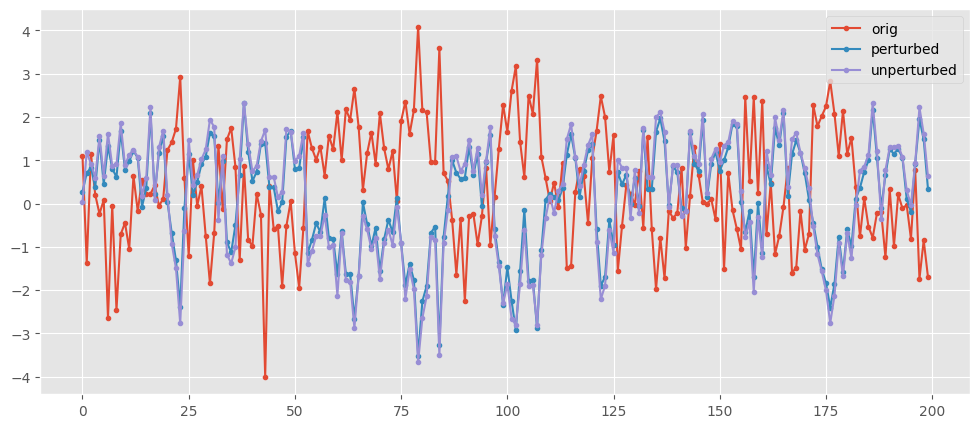

In [95]:
plt.figure(figsize=(12, 5))
xs = np.arange(len(x[0].T[0]))
plt.plot(xs, x[1].T[1], marker=".", label="orig")
plt.plot(xs, yhat1[1].T[0].detach(), marker=".", label="perturbed")
plt.plot(xs, y_target1[1].T[0].detach(), marker=".", label="unperturbed")
plt.legend()
plt.show()

In [59]:
x[0].T.size()
yhat1[0].T.size()

torch.Size([2, 200])

ValueError: All arrays must be of the same length

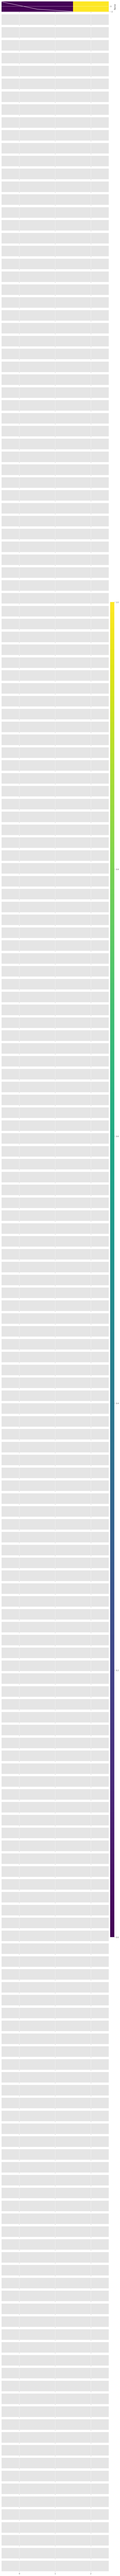

In [55]:
# HMM
plot_saliency(
    x[sample_id], yhat1[sample_id], extremal_attr_batch[sample_id]
)

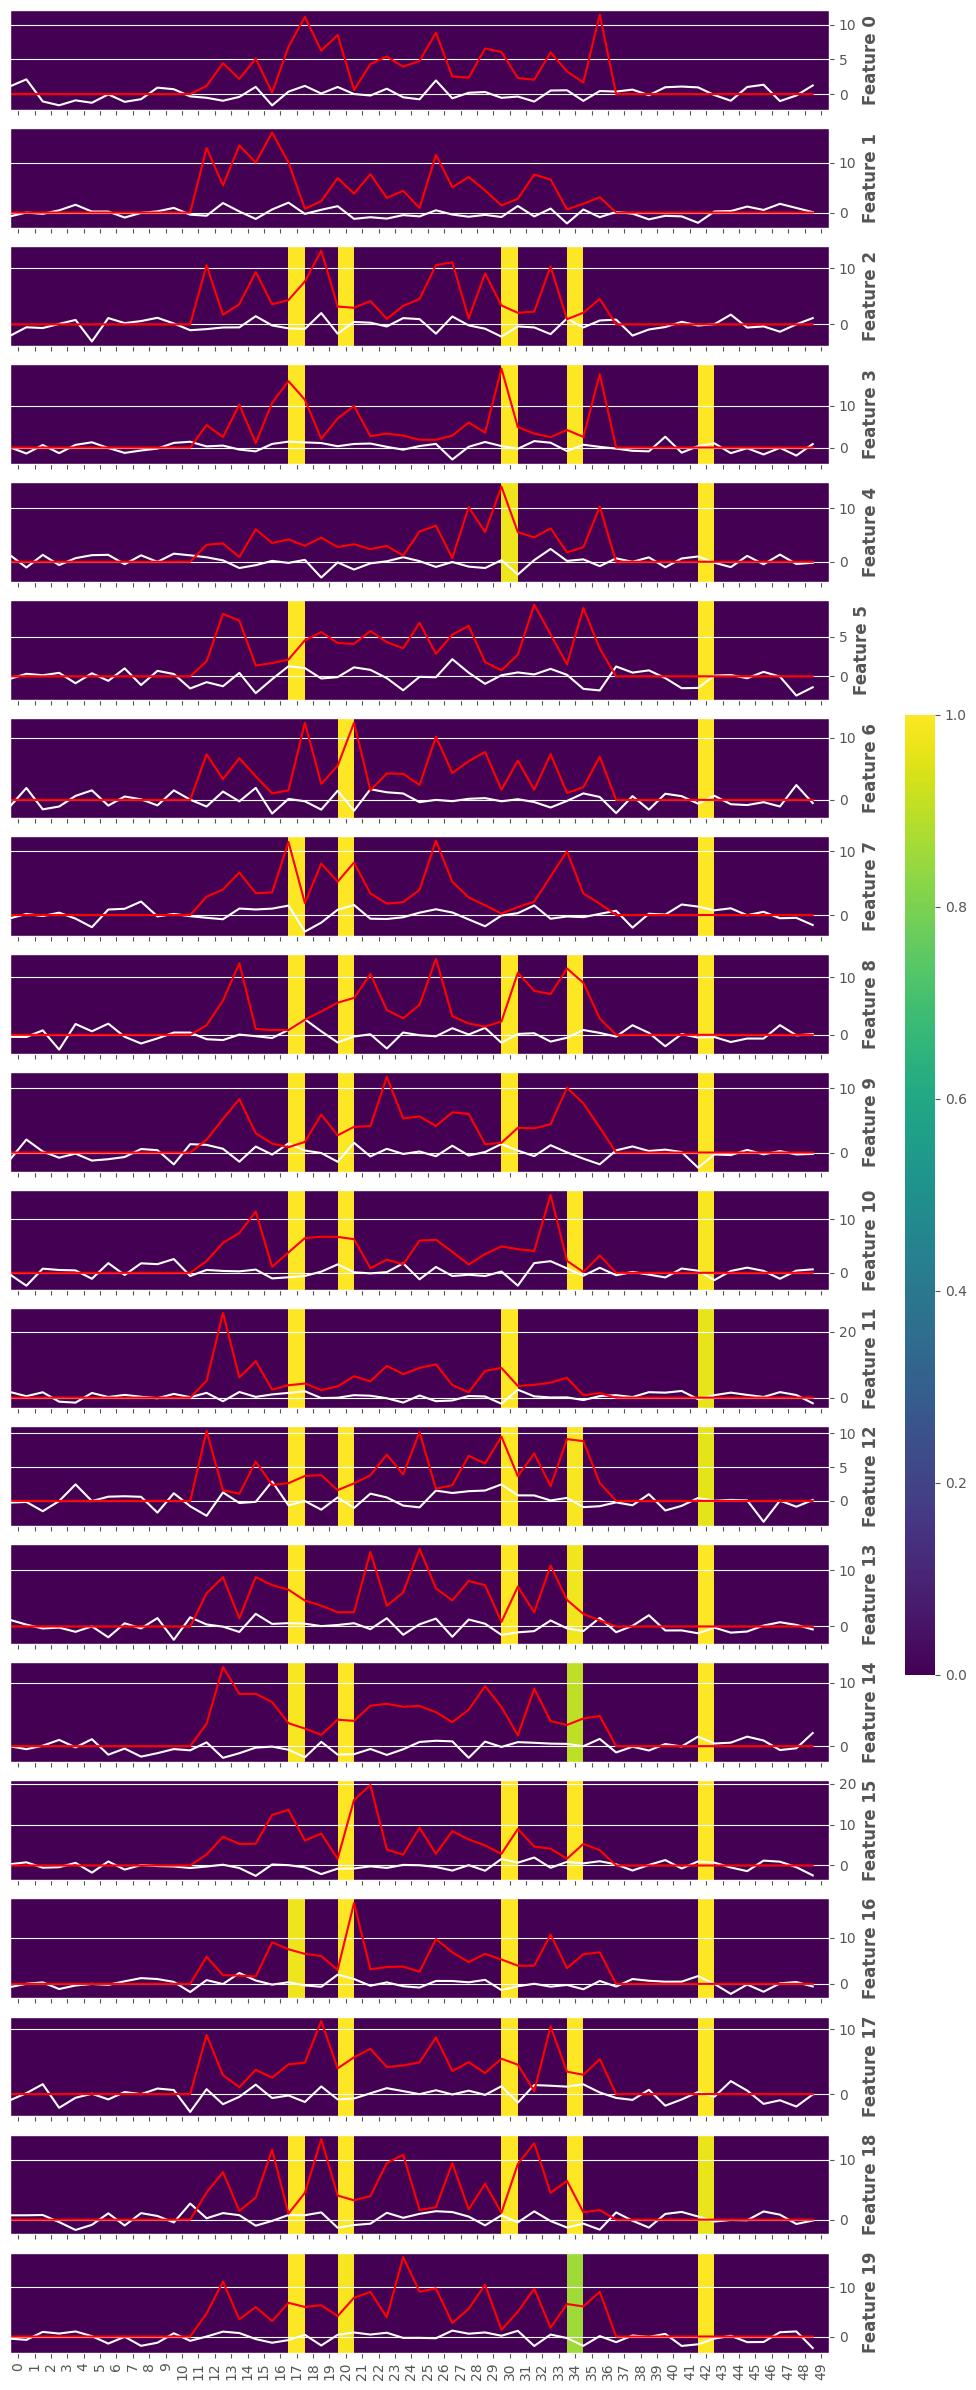

In [53]:
# ARMA
FROM = 10
TO = 30
plot_saliency(
    x[sample_id][FROM:TO], yhat1[FROM:TO], extremal_attr_batch[sample_id][FROM:TO]
)

In [ ]:
# batch_size = extremal_mask_net.net.batch_size
batch_size = x.size()[0]
batch_idx = 1

mask = extremal_mask_net.net.mask
print(mask.size())
mask = mask[batch_size * batch_idx : batch_size * (batch_idx + 1)]

mask = mask.clamp(0, 1)
mask = mask[:, : x.shape[1], ...]
print(x.size())
print(mask.size())
print(baseline.size())
x1 = x * mask + baseline * (1.0 - mask)
x2 = x * (1.0 - mask) + baseline * mask

In [ ]:
FROM = 0
TO = 20
plot_saliency(inputs[0][FROM:TO], yhat1[FROM:TO], extremal_attr[0][FROM:TO])

In [ ]:
FROM = 0
TO = 20
plot_saliency(inputs[0][FROM:TO], x1[0][FROM:TO], true_saliencies[0][FROM:TO])

In [ ]:
idx = 14
plt.plot(np.arange(len(inputs[0][idx])), inputs[0][idx], label="orig", marker=".")
plt.plot(
    np.arange(len(inputs[0][idx])),
    x1[0][idx].detach().numpy(),
    marker=".",
    label="perturbed",
)
plt.legend()
plt.show()

In [ ]:
import random
import torch as th

from captum.attr import (
    IntegratedGradients,
    FeaturePermutation,
    ShapleyValueSampling,
)
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger

from tint.attr import (
    DynaMask,
    ExtremalMask,
    Occlusion,
)
from tint.attr.models import ExtremalMaskNet, MaskNet


def train_dynamask(
    x, true_saliency, max_epochs=1000, device="cpu", device_id=1, deterministic=False
):
    trainer = Trainer(
        max_epochs=max_epochs,
        # accelerator=accelerator,
        devices=device_id,
        deterministic=deterministic,
        logger=TensorBoardLogger(
            save_dir=".",
            version=random.getrandbits(128),
        ),
    )
    mask = MaskNet(
        forward_func=arma.get_white_box,
        perturbation="gaussian_blur",
        keep_ratio=list(np.arange(0.001, 0.051, 0.001)),
        size_reg_factor_init=1,
        size_reg_factor_dilation=1000,
        optim="adam",
        lr=0.001,
    )
    explainer = DynaMask(arma.get_white_box)
    _attr = explainer.attribute(
        x,
        trainer=trainer,
        mask_net=mask,
        batch_size=50,
        additional_forward_args=(true_saliency,),
        return_best_ratio=True,
    )
    print(f"Best keep ratio is {_attr[1]}")
    return _attr[0]


def train_extremal_mask(
    x, true_saliency, max_epochs=2000, device="cpu", device_id=1, deterministic=False
):
    trainer = Trainer(
        max_epochs=max_epochs,
        # accelerator=accelerator,
        devices=device_id,
        log_every_n_steps=2,
        deterministic=deterministic,
        logger=TensorBoardLogger(
            save_dir=".",
            version=random.getrandbits(128),
        ),
    )
    mask = ExtremalMaskNet(
        forward_func=arma.get_white_box,
        optim="adam",
        lr=0.01,
    )
    explainer = ExtremalMask(arma.get_white_box)
    _attr = explainer.attribute(
        x,
        trainer=trainer,
        mask_net=mask,
        batch_size=50,
        additional_forward_args=(true_saliency,),
    )
    return _attr


def train_integrated_gradients(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = IntegratedGradients(forward_func=arma.get_white_box)
        baseline = inputs * 0
        attr[i] = explainer.attribute(
            inputs,
            baselines=baseline,
            additional_forward_args=(saliency,),
        ).abs()

    return attr


def train_occlusion(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = Occlusion(forward_func=arma.get_white_box)
        baseline = th.mean(inputs, dim=0, keepdim=True)
        attr[i] = explainer.attribute(
            inputs,
            sliding_window_shapes=(1,),
            baselines=baseline,
            additional_forward_args=(saliency,),
        ).abs()
    return attr


def train_permutation(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = FeaturePermutation(forward_func=arma.get_white_box)
        attr[i] = explainer.attribute(
            inputs,
            additional_forward_args=(saliency,),
        ).abs()
    return attr


def train_shapley_values(x, true_saliency):
    attr = th.zeros_like(x)
    for i, (inputs, saliency) in enumerate(zip(x, true_saliency)):
        explainer = ShapleyValueSampling(forward_func=arma.get_white_box)
        baseline = th.mean(inputs, dim=0, keepdim=True)
        attr[i] = explainer.attribute(
            inputs,
            baselines=baseline,
            additional_forward_args=(saliency,),
        ).abs()
    return attr

## Extremal Mask

In [ ]:
import torch
from tint.attr import ExtremalMask
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
extremal_explainer = ExtremalMask(mlp)

In [ ]:
inputs.size()

In [ ]:
trainer = Trainer(
    max_epochs=500,
    # accelerator=accelerator,
    devices=1,
    log_every_n_steps=2,
    deterministic=False,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)
mask = ExtremalMaskNet(
    forward_func=arma.get_white_box,
    optim="adam",
    lr=0.01,
)
explainer = ExtremalMask(arma.get_white_box)
_attr = explainer.attribute(
    inputs,
    trainer=trainer,
    mask_net=mask,
    batch_size=50,
    additional_forward_args=(true_saliencies,),
)

In [ ]:
attr_extremal, extrmask_net, extremal_explainer = train_extremal_mask(
    inputs, true_saliencies, max_epochs=500
)
save_explainer(attr_extremal, explainer_name="extremal_attr")
save_explainer(extrmask_net, explainer_name="extremal_mask_net")
save_explainer(extremal_explainer, explainer_name="extremal_explainer")

In [ ]:
mask_net.forward(inputs[0])
mask_net

In [ ]:
# Fit explainer on inputs given the MLP
attr_extremal = extremal_explainer.attribute(inputs)
save_explainer(attr_extremal, mlp, explainer_name="extremal")

In [ ]:
from tint.metrics.white_box import aup, aur, rmse

print(f"AUP: {aup(attr_extremal, true_saliencies):.4}")
print(f"AUR: {aur(attr_extremal, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_extremal, true_saliencies):.4}")

In [ ]:
plot_saliency(inputs[0], attr_extremal[0])

In [ ]:
SAL_ID = 20
saliencies = {
    "true": true_saliencies[SAL_ID],
    "extremal": attr_extremal[SAL_ID],
}
plot_saliency2(saliencies)

## Dynamic Mask

In [ ]:
attr_dynamask, dynamask_net, dynamask_explainer = train_dynamask(
    inputs, true_saliencies, max_epochs=500
)
save_explainer(attr_extremal, explainer_name="attr_dynamask")
save_explainer(mask_net, explainer_name="dynamask_net")
save_explainer(explainer, explainer_name="dynamask_explainer")

In [ ]:
import torch
from tint.attr import DynaMask
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
dynamask_explainer = DynaMask(mlp)

In [ ]:
attr_dynamask = dynamask_explainer.attribute(inputs)
save_explainer(attr_dynamask, mlp, explainer_name="dynamask")

In [ ]:
print(f"AUP: {aup(attr_dynamask, true_saliencies):.4}")
print(f"AUR: {aur(attr_dynamask, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_dynamask, true_saliencies):.4}")

In [ ]:
plot_saliency(inputs[0], attr_dynamask[0])

## Temporal Integrated Gradient

In [ ]:
import torch
from tint.attr import TemporalIntegratedGradients
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
tig_explainer = TemporalIntegratedGradients(mlp)

In [ ]:
attr_tig = tig_explainer.attribute(inputs, target=0)
save_explainer(attr_tig, mlp, explainer_name="tig")

In [ ]:
print(f"AUP: {aup(attr_tig, true_saliencies):.4}")
print(f"AUR: {aur(attr_tig, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_tig, true_saliencies):.4}")

In [ ]:
plot_saliency(inputs[0], attr_tig[0])

In [ ]:
# From ExtremalMaskNN
def forward(
    self,
    x: th.Tensor,
    batch_idx,
    baselines,
    target,
    *additional_forward_args,
) -> (th.Tensor, th.Tensor):
    mask = self.mask

    # Subset sample to current batch
    mask = mask[self.batch_size * batch_idx : self.batch_size * (batch_idx + 1)]

    # We clamp the mask
    mask = mask.clamp(0, 1)

    # If model is provided, we use it as the baselines
    if self.model is not None:
        baselines = self.model(x - baselines)

    # Mask data according to samples
    # We eventually cut samples up to x time dimension
    # x1 represents inputs with important features masked.
    # x2 represents inputs with unimportant features masked.
    mask = mask[:, : x.shape[1], ...]
    x1 = x * mask + baselines * (1.0 - mask)
    x2 = x * (1.0 - mask) + baselines * mask

    # Return f(perturbed x)
    return (
        _run_forward(
            forward_func=self.forward_func,
            inputs=x1,
            target=target,
            additional_forward_args=additional_forward_args,
        ),
        _run_forward(
            forward_func=self.forward_func,
            inputs=x2,
            target=target,
            additional_forward_args=additional_forward_args,
        ),
    )


def representation(self):
    return self.mask.detach().cpu().clamp(0, 1)


# From ExtremalMaskNet


def step(self, batch, batch_idx, stage):
    # x is the data to be perturbed
    # y is the same data without perturbation
    x, y, baselines, target, *additional_forward_args = batch

    # If additional_forward_args is only one None,
    # set it to None
    if additional_forward_args == [None]:
        additional_forward_args = None

    # Get perturbed output
    # y_hat1 is computed by masking important features
    # y_hat2 is computed by masking unimportant features
    if additional_forward_args is None:
        y_hat1, y_hat2 = self(x.float(), batch_idx, baselines, target)
    else:
        y_hat1, y_hat2 = self(
            x.float(),
            batch_idx,
            baselines,
            target,
            *additional_forward_args,
        )

    # Get unperturbed output for inputs and baselines
    y_target1 = _run_forward(
        forward_func=self.net.forward_func,
        inputs=y,
        target=target,
        additional_forward_args=tuple(additional_forward_args)
        if additional_forward_args is not None
        else None,
    )
    y_target2 = _run_forward(
        forward_func=self.net.forward_func,
        inputs=th.zeros_like(y) + baselines,
        target=target,
        additional_forward_args=tuple(additional_forward_args)
        if additional_forward_args is not None
        else None,
    )

    # Add L1 loss
    if self.preservation_mode:
        mask_ = self.lambda_1 * self.net.mask.abs()
    else:
        mask_ = self.lambda_1 * (1.0 - self.net.mask).abs()

    if self.net.model is not None:
        mask_ = mask_[
            self.net.batch_size * batch_idx : self.net.batch_size * (batch_idx + 1)
        ]
        mask_ += self.lambda_2 * self.net.model(x - baselines).abs()
    loss = mask_.mean()

    # Add preservation and deletion losses if required
    if self.preservation_mode:
        loss += self.loss(y_hat1, y_target1)
    else:
        loss += self.loss(y_hat2, y_target2)

    return loss


@log_usage()
def attribute(
    self,
    inputs: TensorOrTupleOfTensorsGeneric,
    baselines: BaselineType = None,
    target: TargetType = None,
    additional_forward_args: Any = None,
    trainer: Trainer = None,
    mask_net: ExtremalMaskNet = None,
    batch_size: int = 32,
    temporal_additional_forward_args: Tuple[bool] = None,
    return_temporal_attributions: bool = False,
) -> TensorOrTupleOfTensorsGeneric:
    """
    Attribute method.

    Args:
        inputs (tensor or tuple of tensors):  Input for which occlusion
            attributions are computed. If forward_func takes a single
            tensor as input, a single input tensor should be provided.
            If forward_func takes multiple tensors as input, a tuple
            of the input tensors should be provided. It is assumed
            that for all given input tensors, dimension 0 corresponds
            to the number of examples (aka batch size), and if
            multiple input tensors are provided, the examples must
            be aligned appropriately.
        baselines (scalar, tensor, tuple of scalars or tensors, optional):
            Baselines define reference value which replaces each
            feature when occluded.
            Baselines can be provided as:

            - a single tensor, if inputs is a single tensor, with
                exactly the same dimensions as inputs or
                broadcastable to match the dimensions of inputs

            - a single scalar, if inputs is a single tensor, which will
                be broadcasted for each input value in input tensor.

            - a tuple of tensors or scalars, the baseline corresponding
                to each tensor in the inputs' tuple can be:

                - either a tensor with matching dimensions to
                corresponding tensor in the inputs' tuple
                or the first dimension is one and the remaining
                dimensions match with the corresponding
                input tensor.

                - or a scalar, corresponding to a tensor in the
                inputs' tuple. This scalar value is broadcasted
                for corresponding input tensor.

            In the cases when `baselines` is not provided, we internally
            use zero scalar corresponding to each input tensor.
            Default: None
        target (int, tuple, tensor or list, optional):  Output indices for
            which difference is computed (for classification cases,
            this is usually the target class).
            If the network returns a scalar value per example,
            no target index is necessary.
            For general 2D outputs, targets can be either:

            - a single integer or a tensor containing a single
                integer, which is applied to all input examples

            - a list of integers or a 1D tensor, with length matching
                the number of examples in inputs (dim 0). Each integer
                is applied as the target for the corresponding example.

            For outputs with > 2 dimensions, targets can be either:

            - A single tuple, which contains #output_dims - 1
                elements. This target index is applied to all examples.

            - A list of tuples with length equal to the number of
                examples in inputs (dim 0), and each tuple containing
                #output_dims - 1 elements. Each tuple is applied as the
                target for the corresponding example.

            Default: None
        additional_forward_args (any, optional): If the forward function
            requires additional arguments other than the inputs for
            which attributions should not be computed, this argument
            can be provided. It must be either a single additional
            argument of a Tensor or arbitrary (non-tuple) type or a
            tuple containing multiple additional arguments including
            tensors or any arbitrary python types. These arguments
            are provided to forward_func in order following the
            arguments in inputs.
            For a tensor, the first dimension of the tensor must
            correspond to the number of examples. For all other types,
            the given argument is used for all forward evaluations.
            Note that attributions are not computed with respect
            to these arguments.
            Default: None
        trainer (Trainer): Pytorch Lightning trainer. If ``None``, a
            default trainer will be provided.
            Default: None
        mask_net (BayesMaskNet): A Mask model. If ``None``, a default model
            will be provided.
            Default: None
        batch_size (int): Batch size for Mask training.
            Default: 32
        temporal_additional_forward_args (tuple): Set each
            additional forward arg which is temporal.
            Only used with return_temporal_attributions.
            Default: None
        return_temporal_attributions (bool): Whether to return
            attributions for all times or not.
            Default: False

    Returns:
        - **attributions** (*tensor* or tuple of *tensors*):
            The attributions with respect to each input feature.
            Attributions will always be
            the same size as the provided inputs, with each value
            providing the attribution of the corresponding input index.
            If a single tensor is provided as inputs, a single tensor is
            returned. If a tuple is provided for inputs, a tuple of
            corresponding sized tensors is returned.
    """
    # Keeps track whether original input is a tuple or not before
    # converting it into a tuple.
    is_inputs_tuple = _is_tuple(inputs)
    inputs = _format_inputs(inputs)

    # Format and validate baselines
    baselines = _format_baseline(baselines, inputs)
    _validate_input(inputs, baselines)

    # Init trainer if not provided
    if trainer is None:
        trainer = Trainer(max_epochs=100)
    else:
        trainer = copy.deepcopy(trainer)

    # Assert only one input, as the Retain only accepts one
    assert len(inputs) == 1, "Multiple inputs are not accepted for this method"
    data = inputs[0]
    baseline = baselines[0]

    # If return temporal attr, we expand the input data
    # and multiply it with a lower triangular mask
    if return_temporal_attributions:
        data, additional_forward_args, _ = _add_temporal_mask(
            inputs=data,
            additional_forward_args=additional_forward_args,
            temporal_additional_forward_args=temporal_additional_forward_args,
        )

    # Init MaskNet if not provided
    if mask_net is None:
        mask_net = ExtremalMaskNet(forward_func=self.forward_func)

    # Init model
    mask_net.net.init(input_size=data.shape, batch_size=batch_size)

    # Prepare data
    dataloader = DataLoader(
        TensorDataset(
            *(data, data, baseline, target, *additional_forward_args)
            if additional_forward_args is not None
            else (data, data, baseline, target, None)
        ),
        batch_size=batch_size,
        collate_fn=default_collate,
    )

    # Fit model
    trainer.fit(mask_net, train_dataloaders=dataloader)

    # Set model to eval mode and cast it to device
    mask_net.eval()
    mask_net.to(data.device)

    # Get attributions as mask representation
    attributions = mask_net.net.representation()

    # Reshape representation if temporal attributions
    if return_temporal_attributions:
        attributions = attributions.reshape((-1, data.shape[1]) + data.shape[1:])

    # Reshape as a tuple
    attributions = (attributions,)

    # Format attributions and return
    return _format_output(is_inputs_tuple, attributions)